In the traditional machine learning domain, building robust and meaningful features can significantly improve final model performance. As a result, in this notebook, I intend to demonstrate the capability of this package on the automated future construction. For the sake of simplicity, I chose a problem from the scikit-learn package as the case study problem. The task is called "diabetes," and its goal is to predict a quantitative measure of disease progression one year after baseline. First, we split the data into a training and a testing set, then train an extremely randomized forest and an evolutionary forest separately and test them on the testing set.


In [3]:
import random

import numpy as np

from lightgbm import LGBMRegressor
from sklearn.datasets import load_diabetes
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from evolutionary_forest.utils import get_feature_importance, plot_feature_importance, feature_append
from evolutionary_forest.forest import GPRegressor
from evolutionary_forest.forest import cross_val_score

random.seed(0)
np.random.seed(0)

X, y = load_diabetes(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
r = ExtraTreesRegressor()
r.fit(x_train, y_train)
print(r2_score(y_test, r.predict(x_test)))
r = GPRegressor(max_height=8, normalize=True, select='AutomaticLexicase',
                gene_num=10, boost_size=100, n_gen=100, base_learner='Random-DT',
                verbose=True)
r.fit(x_train, y_train)
print(r2_score(y_test, r.predict(x_test)))

0.24200875434994717
   	      	                                fitness                                 	                      size                     
   	      	------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max     	min      	nevals	std     	avg  	gen	max	min	nevals	std    
0  	50    	0.204033	0  	0.629683	-0.148491	50    	0.156795	42.68	0  	58 	32 	50    	5.27045
1  	31    	0.181929	1  	0.513633	-0.0795829	31    	0.14764 	42.16	1  	52 	32 	31    	5.5834 
2  	50    	0.162605	2  	0.470697	-0.0540318	50    	0.111865	40.48	2  	56 	32 	50    	5.09996
3  	50    	0.155975	3  	0.452086	-0.124381 	50    	0.10858 	40.28	3  	54 	32 	50    	4.7161 
4  	50    	0.168495	4  	0.523202	-0.115035 	50    	0.125057	40.52	4  	52 	32 	50    	5.10388
5  	50    	0.174687	5  	0.622932	-0.115786 	50    	0.160154	40.64	5  	54 	34 	50    	5.0666 
6  	50    	0.167968	6  	0.52093 	-0.197244 	50    	0.14623 	41.4 	6

Based on this result, we can see that the evolutionary forest outperforms the traditional extremely randomized trees. However, we should not be satisfied with simply having a better model. In fact, a more important goal is to obtain more explainable features, which can improve the performance of many machine learning models. As a result, in the section that follows, we calculate our future importance based on impurity reduction and then rank all features based on those importance scores. For clarity, our package will only display the top 15 most important features.


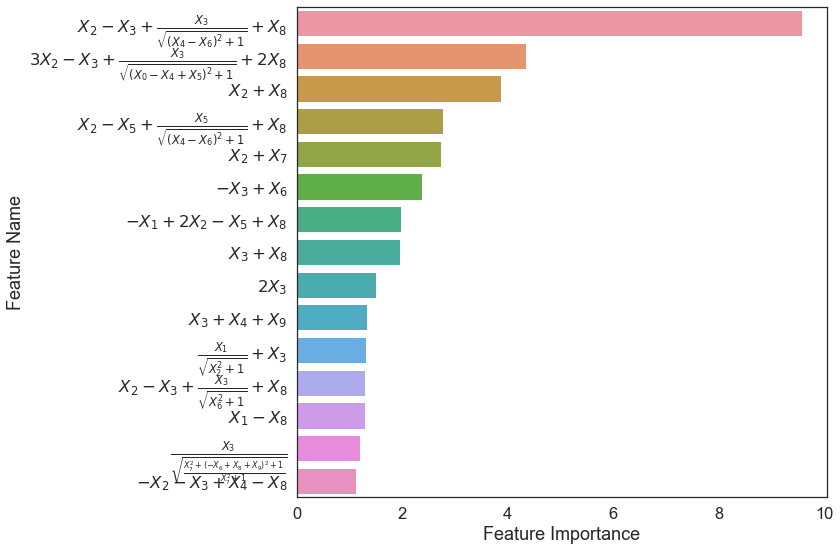

In [4]:
feature_importance_dict = get_feature_importance(r)
plot_feature_importance(feature_importance_dict)

Following the creation of the importance map, we may be able to leverage those useful features in the following section and investigate whether those features can truly improve the performance of an existing model. For the sake of simplicity, we abandoned the use of the original features and only retained the constructed features.

In [5]:
code_importance_dict = get_feature_importance(r, simple_version=False)
new_X = feature_append(r, X, list(code_importance_dict.keys())[:20], only_new_features=True)
new_train = feature_append(r, x_train, list(code_importance_dict.keys())[:20], only_new_features=True)
new_test = feature_append(r, x_test, list(code_importance_dict.keys())[:20], only_new_features=True)
new_r = ExtraTreesRegressor()
new_r.fit(new_train, y_train)
print(r2_score(y_test, new_r.predict(new_test)))

0.22735053357463686


As we can see from the results, the constructed features can truly lead to improved performance, demonstrating the effectiveness of constructed features. However, a more interesting question is whether these features can only be used on this model or if they can also be applied to other machine learning models. So, in the following section, we try to see if these features can be used to improve the performance of existing state-of-the-art machine learning systems.

In [6]:
regressor_list = ['RF', 'ET', 'AdaBoost', 'GBDT', 'DART', 'XGBoost', 'LightGBM', 'CatBoost']

scores_base = []
scores = []

for regr in regressor_list:
    regressor = {
        'RF': RandomForestRegressor(n_jobs=1, n_estimators=100),
        'ET': ExtraTreesRegressor(n_estimators=100),
        'AdaBoost': AdaBoostRegressor(n_estimators=100),
        'GBDT': GradientBoostingRegressor(n_estimators=100),
        'DART': LGBMRegressor(n_jobs=1, n_estimators=100, boosting_type='dart'),
        'XGBoost': XGBRegressor(n_jobs=1, n_estimators=100),
        'LightGBM': LGBMRegressor(n_jobs=1, n_estimators=100),
        'CatBoost': CatBoostRegressor(n_estimators=100, thread_count=1,
                                      verbose=False, allow_writing_files=False),
    }[regr]
    score = cross_val_score(regressor, X, y)
    print(regr, score, np.mean(score))
    scores_base.append(np.mean(score))
    score = cross_val_score(regressor, new_X, y)
    print(regr, score, np.mean(score))
    scores.append(np.mean(score))
scores_base = np.array(scores_base)
scores = np.array(scores)

RF [0.40824192 0.49311056 0.44997218 0.3618319  0.42214539] 0.42706039091677983
RF [0.44306536 0.50402183 0.47622863 0.42296856 0.5532875 ] 0.47991437524320035
ET [0.38898035 0.49331359 0.43865686 0.40275763 0.44906302] 0.4345542909903045
ET [0.44523036 0.45108969 0.4494101  0.43689298 0.5296306 ] 0.4624507462191255
AdaBoost [0.35619236 0.43620547 0.42789169 0.359074   0.4302415 ] 0.4019210044046034
AdaBoost [0.38334106 0.49313328 0.40845526 0.44066282 0.54615262] 0.4543490090315784
GBDT [0.33600425 0.51449987 0.42086809 0.33553521 0.42100346] 0.4055821759046653
GBDT [0.38146594 0.50732176 0.42284714 0.44223534 0.50176805] 0.45112764606496264
DART [0.35379204 0.4339262  0.40526565 0.29617651 0.40656592] 0.37914526592589093
DART [0.38576407 0.40609324 0.4193621  0.40614894 0.49139027] 0.4217517227004402
XGBoost [0.19069273 0.31696014 0.38186465 0.15942315 0.30005706] 0.2697995450013659
XGBoost [0.36546434 0.41669119 0.31477688 0.35176555 0.46445356] 0.38263030648030216
LightGBM [0.35463

As a result of this, we can conclude that constructive features improve the performance of all models. It specifically improves the performance of XGBoost and random forest. As a result of this experiment, we can conclude that our method can be used not only as an effective regression method for inducing a powerful regression model, but also as a feature construction method, which can be used to generate interpretable features and improve the performance of existing machine learning systems. The improvement caused by construction features is depicted in the figure below.

['g' 'g' 'g' 'g' 'g' 'g' 'g' 'g']


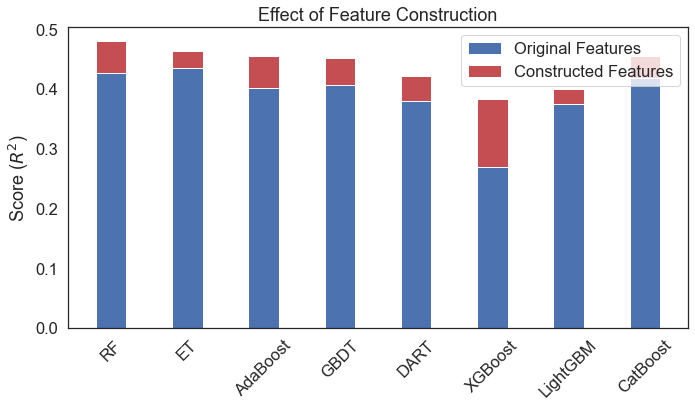

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", font_scale=1.5)
width = 0.4
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(regressor_list, scores_base, width, label='Original Features')
difference = scores - scores_base
print(np.where(difference > 0, 'g', 'y'))
ax.bar(regressor_list, difference, width, bottom=scores_base,
       label='Constructed Features',
       color=np.where(difference > 0, 'r', 'y'))
ax.set_ylabel('Score ($R^2$)')
ax.set_title('Effect of Feature Construction')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Finally, we have shown that our method is capable of discovering useful features that can be used to improve existing machine learning systems. It should be noted, however, that even if the discovered features improve the validation score, there is a risk of overfitting. As a result, in real-world applications, we should validate the obtained model on hold-out testing data to ensure the effectiveness of the newly constructed model.